In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display_html, display, Math, HTML
from scipy.stats import norm
from scipy.stats import uniform
from numpy.random import default_rng

# Parameter Estimation

<!--- Outline

1. Parameter estimation problem 
    * estimator is a procedure
    * bias and variance;  B-V tradeoff (goodfellow p 120)
2. concept of model fitting
    * parameters and data ; notation and concepts (examples)
2. Maximum likelihood principle
    * likelihood is thinking of $p(x; \theta)$ as a function of $\theta$
    * Goodfellow p 128 for defns;  perhaps use some background from earlier pages
3. Simple examples
    * binomial.  solve in closed form
4. Log-likelihood and cross-entropy loss (goodfellow p 129 ff)
    * difference between the distribution of the data and the distribution of the model
    * did not cover this in the end -- should we?
5. Simple examples
    * poisson
6. Model fitting: least squares (godfellow p 130) (they will have seen least squares in DS 121)
    * this is important - introduce the "model for which the method is an MLE" idea
    * but may need to move to next lecture
    * did not cover this in the end
7. Properties of ML estimate (goodfellow p 131)
--->

## Estimators

```{margin}
This section draws from Chapter 5 of _Deep Learning_ by Goodfellow, Bengio, and Courville.
```

A common situation in statistics is the following.   

We are given some data and we want to treat is as an i.i.d. sample from some distribution.  The distribution has certain parameters, such as the mean $\mu$ or the variance $\sigma^2$.  These are assumed to be __fixed__ but __unknown.__

For example, let's say we have the data below.   We want to treat the data as drawn from a Normal distribution $\mathcal{N}(\mu, \sigma^2)$.

What values should we choose for $\mu$ and $\sigma$?

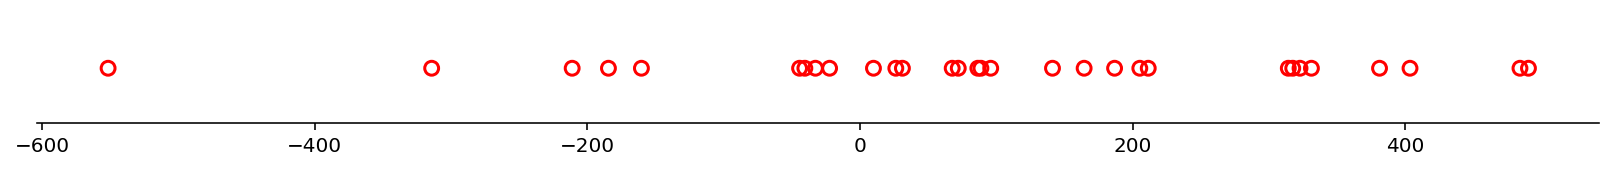

In [2]:
from scipy.stats import norm
from scipy.stats import uniform
from numpy.random import default_rng

# no particular reason for these values
mu = 0
sig = 216
#
samp_size = 30
rng = 0

fig, ax = plt.subplots(1, 1, figsize = (14,1))

# sample
samp_x = norm.rvs(size = samp_size, loc = mu, scale = sig, random_state = rng)
samp_y = [1 for x in samp_x]
ax.scatter(samp_x, samp_y, marker = 'o', facecolors='none', edgecolors='red', linewidths = 1.5, s = 48)
#ax.set_xlim(xmin, xmax)
ax.yaxis.set_visible(False)
# remove the "box" around the plot
for spine in [list(ax.spines.values())[i] for i in [0, 1, 3]]:
    spine.set_visible(False)

We will use $\theta$ (which can be a scalar or a vector) to represent the parameter(s).  For example, we could have $\theta = (\mu, \sigma).$

Let's say our data is $\{x^{(1)}, \dots, x^{(m)}\}$. A __point estimator__ or __statistic__ is any function of the data:

$$ \hat{\theta}_m = g(x^{(1)}, \dots, x^{(m)}). $$

We'll use the hat notation ($\hat{\theta}$) to indicate that we want our point estimator to be an estimate of $\theta$.

In the frequentist perspective on statistics, $\theta$ is __fixed but unknown,__ while $\hat{\theta}$ is a function of the data (and therefore is a __random variable__).

This is a very important perspective to keep in mind;  it is really the defining feature of the frequentist approach to statistics!

__Example.__ Consider a set of samples $\{x^{(1)}, \dots, x^{(m)}\}$ that are independently and identically distributed according to a Bernoulli distribution with mean $\theta$:

$$ p(x^{(i)}; \theta) = \theta^{x^{(i)}}(1-\theta)^{(1-x^{(i)})}. $$

A common estimator for $\theta$ is the mean of the samples:
    
$$ \hat{\theta}_m = g(x^{(1)}, \dots, x^{(m)}) = \frac{1}{m}\sum_{i=1}^m x^{(i)}. $$

### Bias and Variance

How can we tell if an estimator is a good one?

We use two criteria: __bias__ and __variance.__

__Bias.__ The _bias_ of an estimator is defined as:
    
$$ \operatorname{bias}(\hat{\theta}_m) = E[\hat{\theta}_m] - \theta, $$

where the expectation is over the data (seen as samples of a random variable) and $\theta$ is the true underlying value of $\theta$ used to define the data-generating distribution.

An estimator is said to be __unbiased__ if $ \operatorname{bias}(\hat{\theta}_m) = 0$, or in other words $E[\hat{\theta}_m] = \theta$.

Continuing our example for the mean of the Bernoulli:
    
$$ \operatorname{bias}(\hat{\theta}_m) = E[\hat{\theta}_m] - \theta \\
= E\left[\frac{1}{m} \sum_{i=1}^m x^{(i)} \right] - \theta $$

$$ = \frac{1}{m} \sum_{i=1}^m E\left[x^{(i)} \right] - \theta \\
= \frac{1}{m} \sum_{i=1}^m \sum_{x^{(i)}=0}^1 \left(x^{(i)} \theta^{x^{(i)}}(1-\theta)^{(1-x^{(i)})}\right) - \theta $$

$$ \frac{1}{m} \sum_{i=1}^m (\theta) - \theta\\
= \theta - \theta = 0$$

So we have proven that this estimator of $\theta$ is unbiased.

__Variance.__  The _variance_ of an estimator is simply the variance

$$ \operatorname{Var}(\hat{\theta}) = \operatorname{Var}(g(x^{(1)}, \dots, x^{(m)}))$$

where the random variable is the data set.   

Remember that the data set is random; it is assumed to be an i.i.d. sample of some distribution.

Again, using our example of the Bernoulli distribution:  

we know that the estimator $\hat{\theta}_m = \frac{1}{m}\sum_{i=1}^m x^{(i)}$ is simply the mean of $m$ samples of the distribution.

Recalling that variances of i.i.d. RVs sum:

$$\operatorname{Var}\sum_{i=1}^m x^{(i)} = m\operatorname{Var}(x^{(i)}),$$

when we divide the sum by $m$ to get the mean, this divides the variance by $m^2$.)

So we see that that the variance of the mean is:

$$ \operatorname{Var}(\hat{\theta}_m) = \frac{1}{m} \operatorname{Var}(x^{(i)}) $$

Hence we conclude that 

$$ \operatorname{Var}(\hat{\theta}_m) = \frac{1}{m} \theta (1-\theta).$$

This has a desirable property: as the number of samples $m$ increases, the variance of the estimate decreases.

### Mean Squared Error

Consider two estimators, $g$ and $h$, each of which are used as estimates of a certain parameter $\theta$.

Let us say that these estimators show the following distributions:

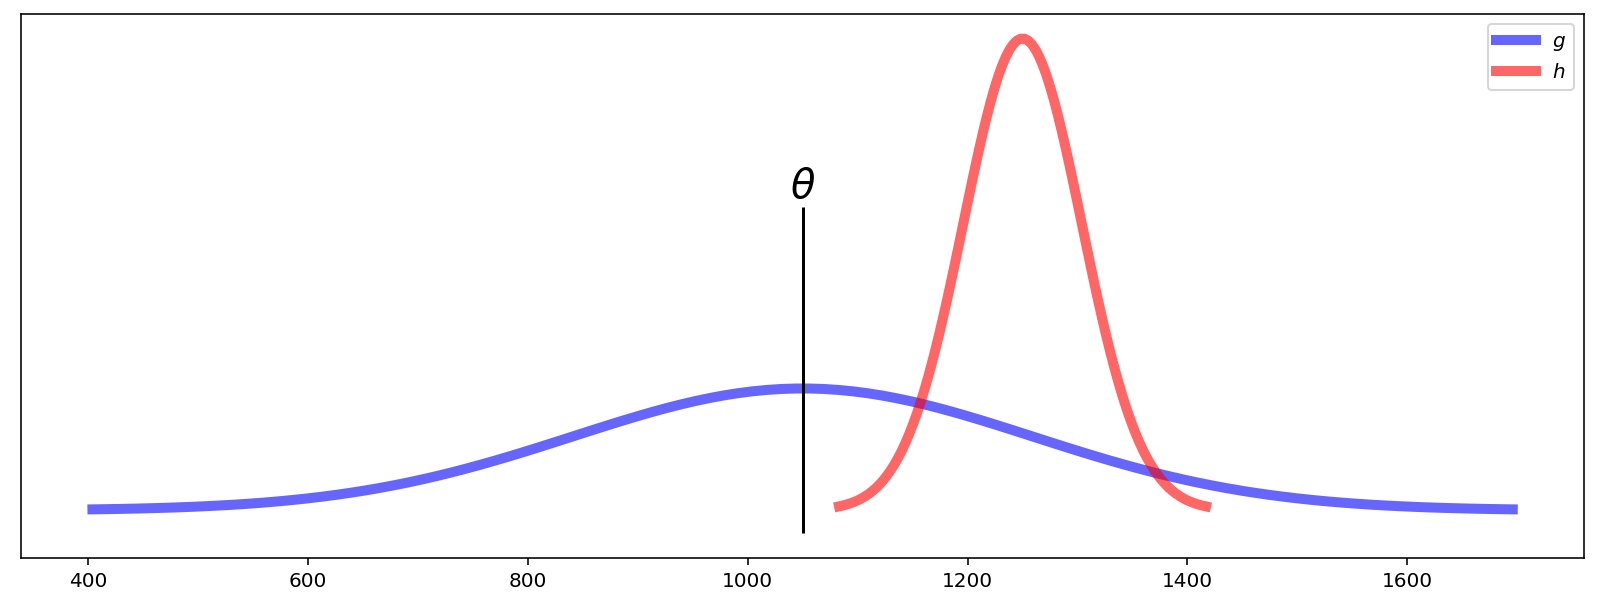

In [3]:
from scipy.stats import norm
from scipy.stats import uniform
from numpy.random import default_rng

rng = default_rng(12)

# just some numbers that make a nice plot
mu = 1050
sig = 209
# MSE of estimator of k having dist (mu, sigma) is sigma^2 + (mu - k)^2
mse1 = sig**2
#
offset = 200
mu2 = mu + offset
sig2 = 54
mse2 = (offset**2) + (sig2**2)
# print(mse1, mse2)
#
samp_size = 15
#
# gaussian curve
fig, ax = plt.subplots(1, 1, figsize = (14,5))
x = np.linspace(norm.ppf(0.001, loc = mu, scale = sig), norm.ppf(0.999, loc = mu, scale = sig), 100)
ax.plot(x, norm.pdf(x, loc = mu, scale = sig),'b-', lw = 5, alpha = 0.6, label = '$g$')
x = np.linspace(norm.ppf(0.001, loc = mu2, scale = sig2), norm.ppf(0.999, loc = mu2, scale = sig2), 100)
ax.plot(x, norm.pdf(x, loc = mu2, scale = sig2),'r-', lw = 5, alpha = 0.6, label = '$h$')
xmin, xmax = (x[0], x[-1])
plt.legend(loc = 'best')
# sample plot
# turn off y axis entirely
ax.yaxis.set_visible(False)
#
# vertical line
ymin, ymax = ax.get_ylim()
plt.vlines(x = mu, ymin = ymin, ymax = ymax-.003, color = 'k')
plt.text(mu, ymax-0.003, r'$\theta$', size = 20, ha = 'center', va = 'bottom');
# hide x axis but not its label
# ax.xaxis.set_major_locator(plt.NullLocator())
# remove the "box" around the plot
#for spine in ax.spines.values():
#    spine.set_visible(False)
# ax.text(1600, np.sum(ax2.get_ylim())/2 - 0.03, 'Sample', size = 16, color = 'red')

The figure shows that estimator $h$ has low variance, but is biased.   Meanwhile, estimator $g$ is unbiased, but has high variance.

Which is better?

The answer of course depends, but there is a single criterion we can use to try to balance these two kinds of errors.

It is __Mean Squared Error.__

$$ \operatorname{MSE}(\hat{\theta}_m) = E[(\hat{\theta}_m - \theta)^2] $$

This measures the "average distance squared" between the estimator and the true value.

It is a good single number for evaluating an estimator, because it turns out that:
    
$$ \operatorname{MSE}(\hat{\theta}_m) = \operatorname{Bias}(\hat{\theta}_m)^2 + \operatorname{Var}(\hat{\theta}_m) $$

For example, the two estimators $g$ and $h$ in the plot above have approximately the same MSE.

## Model Fitting

The notion of parameter estimation leads to a more general concept called _model fitting._

Imagine that you know that data is drawn from a particular __kind__ of distribution, but you don't know the value(s) of the distribution's parameter(s).

We have actually been doing this quite a bit already, but now we want to treat the notion more directly.

We formalize the problem as follows.  We say that data is drawn from a distribution

$$ p(x; \theta) $$

The way to read this is: the probability of $x$ under a distribution having parameter(s) $\theta$.

We call $p(x; \theta)$ a _family_ of distributions because there is a different distribution for each value of $\theta$. 

Model fitting is finding the parameters $\theta$ of the distribution given that we know some data $x$.

Notice that in this context, it is the parameters $\theta$ that are varying (not the data $x$).

When we think of $p(x; \theta)$ as a function of $\theta$ (instead of $x$, say) we call it a __likelihood.__

This change in terminology is just to emphasize that we are thinking about varying $\theta$ when we look at the probability $p(x; \theta)$.

For example, consider the dataset below:

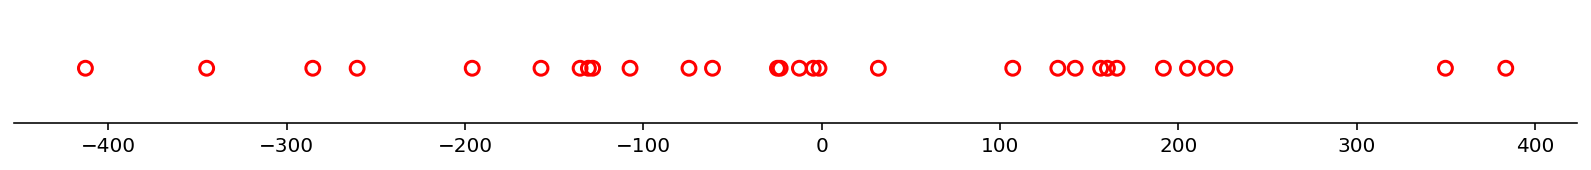

In [4]:
from scipy.stats import norm
from scipy.stats import uniform
from numpy.random import default_rng

# no particular reason for these values
mu = 0
sig = 216
#
samp_size = 30

fig, ax = plt.subplots(1, 1, figsize = (14,1))

# sample
samp_x = norm.rvs(size = samp_size, loc = mu, scale = sig, random_state = rng)
samp_y = [1 for x in samp_x]
ax.scatter(samp_x, samp_y, marker = 'o', facecolors='none', edgecolors='red', linewidths = 1.5, s = 48)
#ax.set_xlim(xmin, xmax)
ax.yaxis.set_visible(False)
# remove the "box" around the plot
for spine in [list(ax.spines.values())[i] for i in [0, 1, 3]]:
    spine.set_visible(False)

Can you imagine that this dataset might be drawn from a Normal distribution?

In that case, 

$$ p(x; \theta) = \mathcal{N}(x; \mu, \sigma^2) $$

Then model fitting would consist of finding the $\mu$ and $\sigma$ that best matches the given data $x$ shown above.

When we consider how the probability of the data shown varies as we vary $\mu$ and $\sigma$, we are dealing with the _likelihood_ of the data.

### Calculating Likelihood

Let's think about how to calculate likelihood.   Consider a set of $m$ data items 

$$ X = \{x^{(1)}, \dots, x^{(m)}\} $$ 

drawn independently from the true but unknown data-generating distribution $p_{\text{data}}(x)$.

Let's let $p_{\text{model}}(x; \theta)$ be a family of probability distributions over the same space.   

Then, for any value of $\theta$, $p_{\text{model}}(x; \theta)$ maps a particular data item $x$ to a real number that we can use as an estimate of the true probability $p_{\text{data}}(x)$.

What is the probability of the entire dataset $X$ under the model?

We assume that the $x^{(i)}$ are independent;  so the probabilities multiply.

So the joint probability is

$$ p_{\text{model}}(X; \theta) = \prod_{i=1}^m p_{\text{model}}(x^{(i)}; \theta). $$

Now, each individual $p_{\text{model}}(x^{(i)}; \theta)$ is a value between 0 and 1.

And there are $m$ of these numbers being multiplied.   So for any reasonable-sized dataset, the joint probability is going to be __very__ small.

For example, if a typical probability is $1/10$, and there are 500 data items, then the joint probability will be a number on the order of $10^{-500}$.   

So the probability of a given dataset as a number will usually be too small to even represent in a computer using standard floating point!

### Log-Likelihood

Luckily, there is an excellent way to handle this problem.  

Instead of using likelihood, we will use the log of likelihood.  

This is fine, because most of the time we are only interested in comparing different likelihoods.  The log function does not change the results of comparisons (it is a monotonic function).  

So we will work with the log-likelihood:

$$  \log p_{\text{model}}(X; \theta) $$

Which becomes:

$$ \log p_{\text{model}}(X; \theta) = \sum_{i=1}^m \log p_{\text{model}}(x^{(i)}; \theta). $$

This way we are no longer multiplying many small numbers, and we work with values that are easy to represent.

Note though that the log of a number less than one is negative, so log-likelihoods are always negative values.

__Example.__

As an example, let's return to Bortkeiwicz's horse-kick data, and see how the log-likelihood changes for different values of the Poisson parameter $\lambda$. 

Recall that Bortkeiwicz had collected deaths by horse-kick in the Prussian army over a span of 200 years, and was curious whether they occurred at a constant, fixed rate. 

To do this he fitted the data to a Poisson distribution.   To do that, he needed to estimate the parameter $\lambda$.   

Let's see how the log-likelihood of the data varies as a function of $\lambda$.

In [12]:
# note that this data is available in 'data/HorseKicks.txt'
horse_kicks = pd.DataFrame(
data = np.array([
[0, 108.67, 109],
[1, 66.29, 65],
[2, 20.22, 22],
[3, 4.11, 3],
[4, 0.63, 1],
[5, 0.08, 0],
[6, 0.01, 0]]),
columns = ["Deaths Per Year","Predicted Instances (Poisson)","Observed Instances"])
horse_kicks["Deaths Per Year"] = horse_kicks["Deaths Per Year"].astype('int')
horse_kicks["Observed Instances"] = horse_kicks["Observed Instances"].astype('int')
horse_kicks[["Deaths Per Year","Observed Instances"]].style.hide(axis='index')

As a reminder, $\lambda$ is rate of deaths per year, and $T = 1$ reflects that we are interested in one-year intervals.

The Poisson distribution predicts:

$$ P[k \mbox{ deaths in time } T] = (\lambda T)^k \frac{e^{- \lambda T}}{k!}$$

Since $T = 1$ we can drop it, and so the likelihood of a particular number of deaths $x^{(i)}$ in year $i$ is:

$$ p(x^{(i)}; \lambda) = \lambda^{x^{(i)}} \frac{e^{- \lambda}}{x^{(i)}!}$$

So the log-likelihood is:

$$ \log p(x^{(i)}; \lambda) = x^{(i)} \log \lambda - \lambda - \log x^{(i)}! $$

Using this we can calculate the log-likelihood of the data, ie:
    
$$ \log p(X; \lambda) = \sum_{i=0}^m \left( x^{(i)} \log \lambda - \lambda - \log x^{(i)}!\right) $$

Which looks like this as we vary $\lambda$:

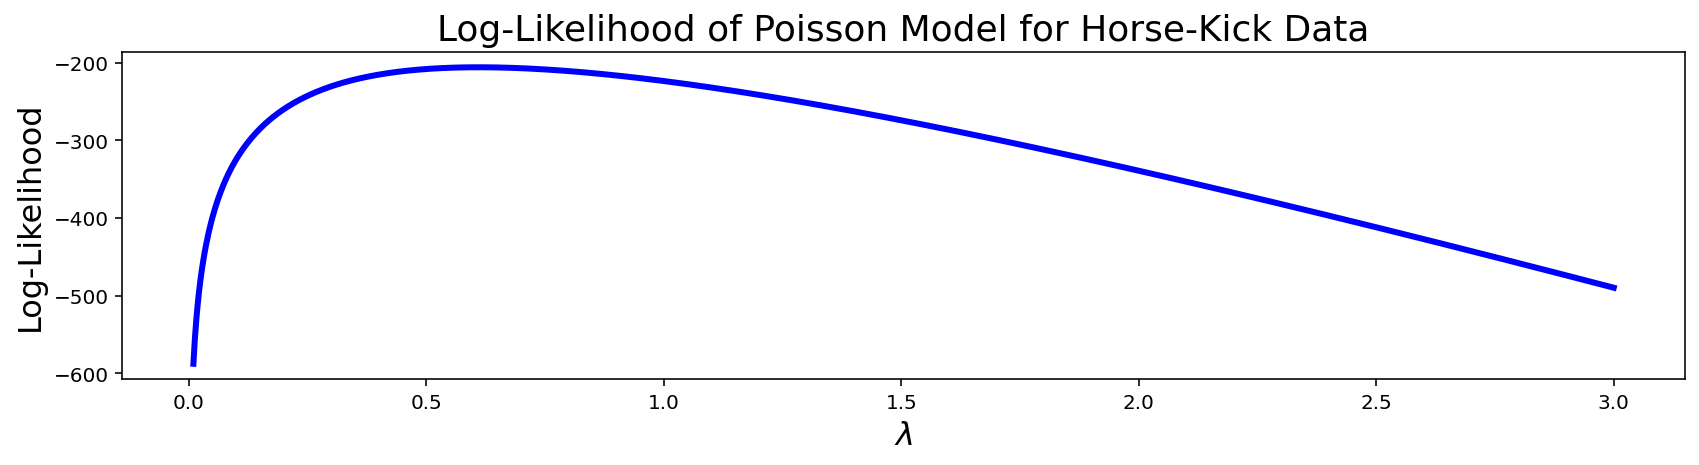

In [6]:
from scipy.stats import poisson

# assumes data is a list of counts for various values starting at zero
def ll(data, lam):
    return np.sum(data * poisson.logpmf(range(len(data)), lam))

xvals = np.linspace(0.01, 3, 1000)
ll_vals = [ll(horse_kicks['Observed Instances'], xval) for xval in xvals]

fig, ax = plt.subplots(1, 1, figsize = (14,3))
plt.plot(xvals, ll_vals, lw = 3, color = 'blue')
plt.ylabel('Log-Likelihood', size = 16)
plt.xlabel(r'$\lambda$', size = 16)
plt.title('Log-Likelihood of Poisson Model for Horse-Kick Data', size = 18);

## The Maximum Likelihood Principle

We have seen some examples of estimators for parameters.   

But where do estimators come from?  

Rather than making guesses about what might be a good estimator, we'd like a principle that we can use to derive good estimators for different models.

The most common principle is the maximum likelihood principle.

Looking back at the deaths-by-horse-kick data, we can see that there is clearly a maximum in the plot of the likelihood function, somewhere between 0.5 and 1.  

If we use the value of $\lambda$ at the maximum, we are choosing to set $\lambda$ to __maximize the likelihood of the data under the model.__

Formally, we say that the __maximum likelihood estimator__ for $\theta$ is:
    
$$ \theta_{\text{ML}} = \arg \max_\theta p_{\text{model}}(X; \theta), $$

which for a dataset of $m$ items is:
    
$$ \theta_{\text{ML}} = \arg \max_\theta \prod_{i=1}^m p_{\text{model}}(x^{(i)}; \theta). $$   

And remember that (because the log function is monotonic) this is the same thing as maximizing the log-likelihood:
    
$$ \theta_{\text{ML}} = \arg \max_\theta \sum_{i=1}^m \log p_{\text{model}}(x^{(i)}; \theta). $$ 

The maximum likelihood estimator has a number of properties that make it the preferred way to estimate parameters whenever possible.   

In particular, under appropriate conditions, the MLE is __consistent__, meaning that as the number of data items grows large, the estimate converges to the true value of the parameter.

It can also be shown that for large $m$, no consistent estimator has a lower MSE than the maximum likelihood estimator.

__Example.__ 

Let's see how to find the MLE for the Poisson distribution, and apply it to the horse-kick data.

We will work with log-likelihood of the data:
    
$$ \log p(X; \lambda) = \sum_{i=0}^m \left(x^{(i)} \log \lambda - \lambda - \log x^{(i)}!\right) $$

We want to find the maximum of this expression as a function of $\lambda$.

The derivative with respect to $\lambda$ is:

$$ \frac{\partial}{\partial\lambda}\log p(X; \lambda) = \sum_{i=0}^m \left(x^{(i)} \frac{1}{\lambda} - 1 \right)\\
= \frac{1}{\lambda}\sum_{i=0}^m x^{(i)} - m $$

Setting the derivative to zero means that $\hat{\lambda}$ is our MLE.  So we get 

$$ 0 = \frac{1}{\hat{\lambda}}\sum_{i=0}^m x^{(i)} - m $$

$$ \hat{\lambda} = \frac{1}{m}\sum_{i=0}^m x^{(i)} $$

Thus we find that the MLE estimate of $\lambda$ (the number of deaths per year) is just the mean of the data, ie, the average number of deaths per year!

From the data above we can compute that $\hat{\lambda}$ = 0.61.

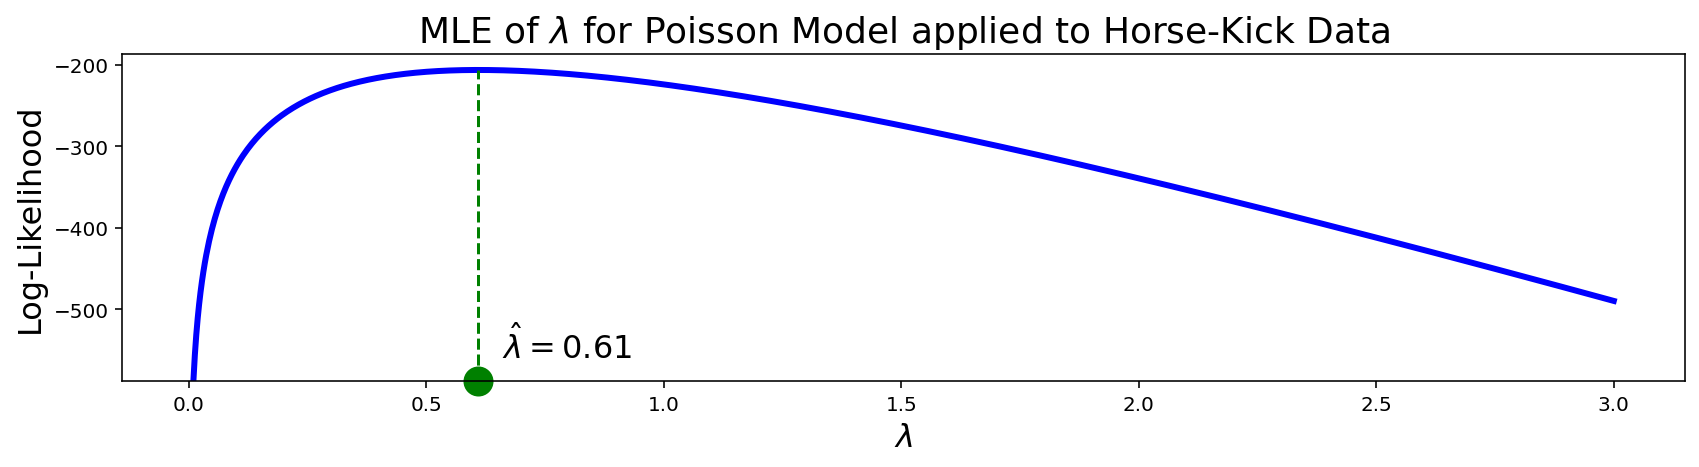

In [7]:
from scipy.stats import poisson

# assumes data is a list of counts for various values starting at zero
def ll(data, lam):
    return np.sum(data * poisson.logpmf(range(len(data)), lam))

xvals = np.linspace(0.01, 3, 1000)
ll_vals = [ll(horse_kicks['Observed Instances'], xval) for xval in xvals]

mle = np.sum((horse_kicks['Observed Instances'] 
    * np.array(range(len(horse_kicks['Observed Instances'])))) /
       np.sum(horse_kicks['Observed Instances']))

fig, ax = plt.subplots(1, 1, figsize = (14,3))
plt.plot(xvals, ll_vals, lw = 3, color = 'blue')

ymin = np.min(ll_vals)
ax.set_ylim(ymin = ymin)
mle_ll = np.sum(horse_kicks['Observed Instances'] *  
                     poisson.logpmf(range(len(horse_kicks['Observed Instances'])), mle))
plt.vlines(x = mle, ymin = ymin, ymax = mle_ll, linestyles = 'dashed', color = 'g')
plt.plot(mle, ymin, 'o', color = 'g', markersize = 14, clip_on = False)
plt.text(mle+0.05, ymin+20, r'$\hat{\lambda} = 0.61$', size = 16, ha = 'left', va = 'bottom')

plt.ylabel('Log-Likelihood', size = 16)
plt.xlabel(r'$\lambda$', size = 16)
plt.title('MLE of $\lambda$ for Poisson Model applied to Horse-Kick Data', size = 18);

Using this estimate for $\lambda$, we can ask what the __expected__ number of deaths per year would be, if deaths by horse-kick really followed the assumptions of the Poisson distribution (ie, happening at a fixed, constant rate):

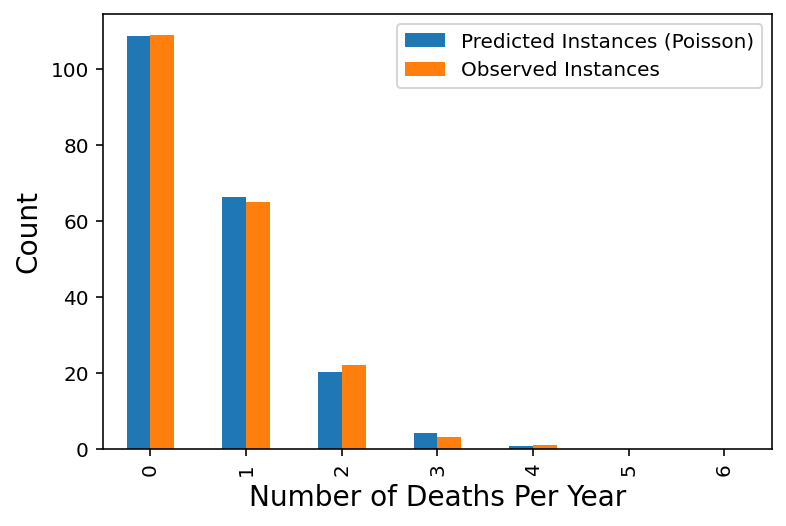

In [8]:
horse_kicks[["Predicted Instances (Poisson)","Observed Instances"]].plot.bar()
plt.xlabel("Number of Deaths Per Year", size=14)
plt.ylabel("Count", size=14);

Which shows that the Poisson model is indeed a very good fit to the data!

From this, Bortkeiwicz concluded that there was nothing particularly unusual about the years when there were many deaths by horse-kick.  They could be just what is expected if deaths occurred at a constant rate.